# Data Visualisations

# CPPN-NEAT vs ES-HyperNEAT

In [2]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Opens CPPN-NEAT and HyperNEAT run files
with open("result data/NEAT-250.pickle", "rb") as f:
    neat = pickle.load(f)

with open("result data/HYPERNEAT-250-FINAL.pickle", "rb") as f:
    es_hyperneat = pickle.load(f)

## Highest Fitness Xenobot in Each Generation

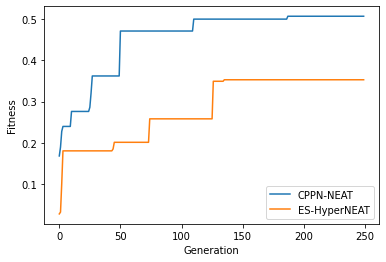

In [3]:
y = list(range(len(neat["best_each_gen"])))

plt.plot(y, neat["best_each_gen"])
plt.plot(y, es_hyperneat["best_each_gen"])
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(["CPPN-NEAT", "ES-HyperNEAT"])


## Standard Deviation of Fitness in Each Generation

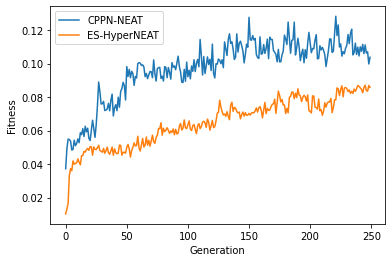

In [4]:
y = list(range(len(neat["std_dev"])))

plt.plot(y, neat["std_dev"])
plt.plot(y, es_hyperneat["std_dev"])

plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(["CPPN-NEAT", "ES-HyperNEAT"])

## Mean Fitness

True


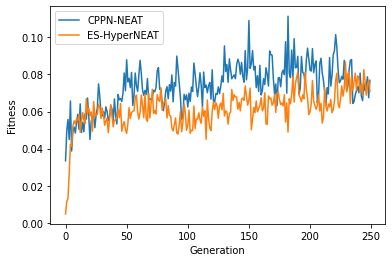

In [5]:
y = list(range(len(neat["mean"])))

plt.plot(y, neat["mean"])
plt.plot(y, es_hyperneat["mean"])

neat_50 = neat["mean"][50]
hyper_50 = es_hyperneat["mean"][50]

neat_m = (neat["mean"][-1] - neat_50) / (250 - 50)
hyper_m = (es_hyperneat["mean"][-1] - hyper_50) / (250 - 50)

print(neat_m < hyper_m)

plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(["CPPN-NEAT", "ES-HyperNEAT"])

## CPPN-NEAT

### Log phenotype probability vs complexity

## ES-HyperNEAT

# Clustering of Xenobots

In [1]:
import json
import umap
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import umap.plot
from sklearn.decomposition import PCA
from tools.clustering import choose_num_clusters
from sklearn.cluster import KMeans, OPTICS
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

2023-03-31 14:11:51.559138: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-31 14:11:51.559154: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## By Structure

### Load dataset

In [2]:
f = open("motif_data.json")
data = json.load(f)

f.close()

motifs = data["motifs"]
xenobots = data["xenobots"]
    
df = pd.DataFrame(xenobots)

df = pd.json_normalize(df["motif_counts"])
    
df

,2429,3266,578,315,4365,4858,3755,259,3954,2159,...,3763,1887,4743,2130,4527,4757,2275,2857,2539,2540
0,2.0,12.0,5.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,4.0,2.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,8.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478595,2.0,6.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
478596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
478597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
478598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Preprocessing

Drop last 428600 rows

In [3]:
df.drop(df.tail(428600).index, inplace=True)

Replace NaN with 0s

In [4]:
df = df.fillna(0)

df

,2429,3266,578,315,4365,4858,3755,259,3954,2159,...,3763,1887,4743,2130,4527,4757,2275,2857,2539,2540
0,2.0,12.0,5.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,4.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,8.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49998,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Dimensionality Reduction

In [5]:
reduced = umap.UMAP(random_state=0, n_components=5).fit(df)
reduced = pd.DataFrame(reduced.embedding_)

reduced

,0,1,2,3,4
0,7.943867,2.906075,6.336430,9.578365,2.873148
1,7.273149,13.642904,4.909186,5.017241,-1.283347
2,6.978176,2.004061,3.717762,4.703365,0.808732
3,7.657124,5.077399,4.437333,13.575477,-0.218582
4,6.740560,10.060383,6.409687,4.747088,7.860538
...,...,...,...,...,...
49995,6.959313,9.928056,6.504022,4.752985,7.502515
49996,6.589849,1.009399,13.578527,-1.886560,-4.359006
49997,6.544333,0.330907,15.123579,0.168143,-5.143355
49998,7.084404,5.301708,6.470180,5.442652,6.335720


### Various algorithms

K-means

Choose optimal number of clusters using silhouette coefficient

/home/cameron/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/cameron/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/cameron/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/cameron/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/cameron/.local/lib/python3

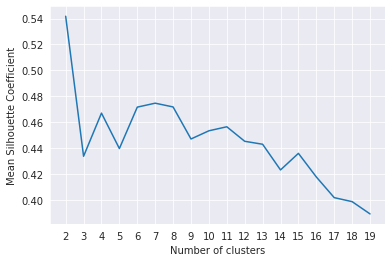

In [32]:
clusters, labels, score = choose_num_clusters(reduced, num_clusters=20, plot=True)

In [33]:
f"clusters: {clusters}. silhouette score: {score}."


'clusters: 2. silhouette score: 0.5418261289596558.'

Run k-means

In [27]:
kmeans = KMeans(n_clusters=5)
labels = kmeans.fit_predict(reduced)

/home/cameron/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Hierarchical Clustering

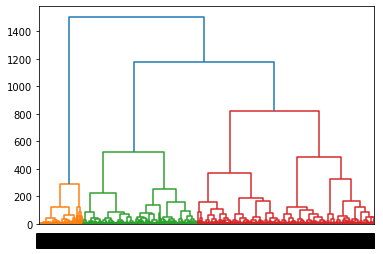

In [6]:
linkage_data = linkage(reduced, method="ward", metric="euclidean")
dendrogram(linkage_data)

plt.show()


In [21]:
hierarchical_cluster = AgglomerativeClustering(distance_threshold=600, n_clusters=None)
hierarchical_labels = hierarchical_cluster.fit_predict(reduced)

Visualisation of Clustering

In [7]:
# random_state=29 
mapper = umap.UMAP(random_state=29).fit(df)

/usr/local/lib/python3.8/dist-packages/umap/plot.py:435: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

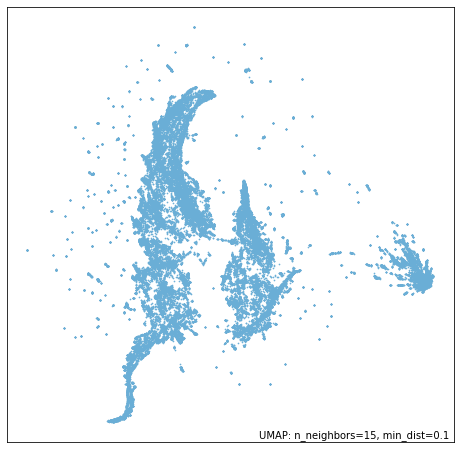

In [8]:
umap.plot.points(mapper)

<Axes: >

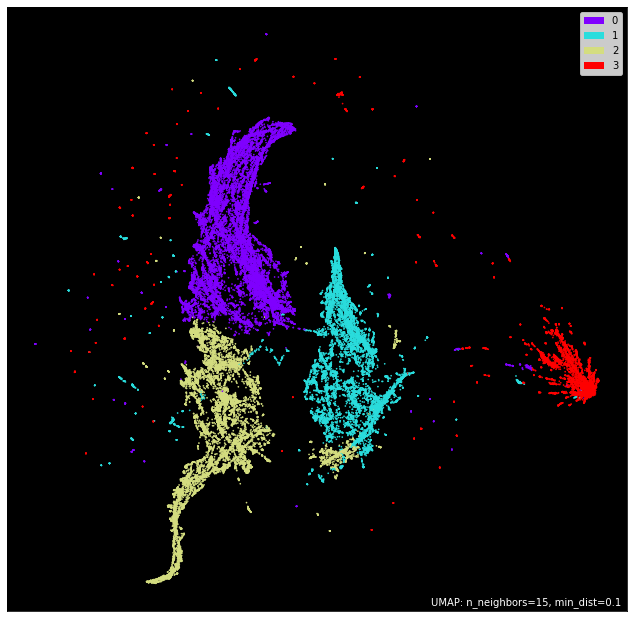

In [22]:
umap.plot.points(mapper, labels=hierarchical_labels, color_key_cmap='Paired', theme='fire')

Cluster Validation

In [13]:
from sklearn.metrics import silhouette_score

silhouette_score(reduced, optics.labels_)

: 

: 

## By Behaviour 